### Check Data Directory and List Example Files

Before processing the CMU10_3D dataset, Verifying that the specified data directory exists and displays the first few files inside it. This helps confirm your paths are set correctly and that your dataset is accessible from your current environment. It also gives a quick glance at the naming structure of your images and masks to avoid issues later in the workflow.


In [2]:
import os

data2d = r"D:/Codes/Assignments/ParallelDots/CMU10_3D/data_2D"  

print("Folder exists?", os.path.exists(data2d))
print("Example image/mask files:", os.listdir(data2d)[:5])

Folder exists? True
Example image/mask files: ['can_chowder_000001.jpg', 'can_chowder_000001_1_gt.png', 'can_chowder_000002.jpg', 'can_chowder_000002_1_gt.png', 'can_chowder_000003.jpg']


### Import Core Libraries, SAM2 Modules, and Define Utility Functions

Setting up the core environment required for zero-shot product detection using SAM2. It performs the following actions:

- **Imports key libraries** for image I/O, numerical computation, and visualization:  
  - `PIL.Image` for image file handling  
  - `numpy` for array operations  
  - `matplotlib.pyplot` and `matplotlib.patches` for plotting and drawing bounding boxes
  - `os` for file/path management

- **Imports SAM2-specific modules** needed to construct and use the model:  
  - `build_sam2` to initialize the core segmentation model  
  - `build_sam2_video_predictor` for video/sequence perception  
  - `SAM2AutomaticMaskGenerator` and `SAM2ImagePredictor` for mask prediction on images

- **Specifies the file locations** for the SAM2 model checkpoint (`sam2_hiera_tiny.pt`) and its configuration YAML.  
  Update these paths if your directory structure differs.

- **Defines two utility functions:**  
  - `create_if_not_exists(dirname)` ensures a temporary or results directory exists (creating it if needed).
  - `cleardir(tempfolder)` deletes all files from a temporary directory, useful for cleaning up between runs.



In [ ]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches

from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = r"D:/Codes/Assignments/ParallelDots/checkpoints/sam2_hiera_tiny.pt"         
model_cfg  = r"D:/Codes/Assignments/ParallelDots/checkpoints/sam2_hiera_t.yaml"        

def create_if_not_exists(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)

def cleardir(tempfolder):
    import glob
    filepaths = glob.glob(tempfolder + "/*")
    for filepath in filepaths:
        os.unlink(filepath)

print("Sam2-related modules imported and utility functions defined.")


Sam2-related modules imported and utility functions defined.


### Initialize SAM2 Model and Predictors

Instantiating all key components of the SAM2 pipeline required for both image and video detection workflows:

- **`predictor_prompt`**: Sets up a prompt-based image predictor by building the SAM2 model using the specified checkpoint and config file. This will be used for prompt-based segmentation tasks.
- **`sam2`**: Initializes the core SAM2 backbone model, explicitly selecting device (`'cuda'` for GPU, switch to `'cpu'` if no GPU is available) and disabling post-processing if desired. This object is fundamental for mask generation and batch image inference.
- **`mask_generator`**: Prepares the automatic mask generator which generates segmentation masks over an input image by leveraging the SAM2 backbone.
- **`predictor_vid`**: Sets up the video (sequence) predictor, enabling object propagation and mask tracking across multiple frames via the SAM2 engine.
- **`tempfolder`**: Defines the path for a temporary working directory where intermediate files (such as extracted video frames or temporary images) can be safely stored.
- **Status Print**: A confirmation message is printed to reflect that all predictors and models have been initialized and are ready for downstream tasks.


In [ ]:
predictor_prompt = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

sam2 = build_sam2(model_cfg, checkpoint, device='cuda', apply_postprocessing=False)  # use 'cpu' if no GPU

mask_generator = SAM2AutomaticMaskGenerator(sam2)

predictor_vid = build_sam2_video_predictor(model_cfg, checkpoint, device='cuda')  # use 'cpu' if no GPU

tempfolder = "./tempdir"

print("SAM2 model and all predictors initialized! Ready for analysis.")

SAM2 model and all predictors initialized! Ready for analysis.


### Bounding Box Extraction from Ground-Truth Mask

Defining a utility function, `process_img_png_mask`, which extracts the smallest possible bounding box covering the foreground object in a binary ground-truth mask (PNG). The function serves two core purposes:

- **Bounding box extraction:**  
  Given a binary mask, it computes the indices where the object exists (non-zero pixels) to determine the limits of the bounding rectangle, returning the coordinates as `[xmin, xmax, ymin, ymax]`. This tight box is essential for both evaluating ground truth and for providing prompt inputs to the SAM2 model in zero-shot detection.

- **(Optional) Visualization:**  
  If `visualize=True`, the function overlays the computed bounding box on the corresponding image using matplotlib, giving the user a quick visual check of the region that will be used as the detection or segmentation prompt.


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def process_img_png_mask(img_path, mask_path, visualize=False):
    """
    Extracts bounding box [xmin, xmax, ymin, ymax] from a binary GT mask (PNG).
    Optionally, overlays the box on the image for visualization.
    """
    mask = np.array(Image.open(mask_path))
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    if visualize:
        img = Image.open(img_path)
        plt.imshow(img)
        plt.gca().add_patch(
            plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='r', facecolor='none', linewidth=2)
        )
        plt.title("Bounding Box on Sample Image")
        plt.show()
    return [int(xmin), int(xmax), int(ymin), int(ymax)]


### Run SAM2 Zero-Shot Detection and Visualize Results

Conducting zero-shot object detection using the SAM2 pipeline for a selected product. The workflow follows these key steps:

- **Bounding Box Extraction:**  
  The bounding box for the target product (e.g., "can_chowder_000001") is extracted from the ground-truth mask using `process_img_png_mask`. This box is formatted as a prompt (`box_list`) for the segmentation model.

- **Detection with `track_item_boxes`:**  
  The function takes as input:
  - The reference (prompt) image and its bounding box,
  - A test image for evaluation,
  - The list of prompts (bounding boxes with object ids).
  
  Internally, it:
  1. Prepares a temporary directory with working copies of the images.
  2. Initializes SAM2's video predictor and sets up state for mask propagation.
  3. Runs tracking/detection using the bounding box as a prompt, calling `predictor_vid.add_new_points_or_box`.
  4. Handles output type flexibly for robust inference.

- **Visual Feedback:**  
  If visualizing (`visualize=True`):
  - Displays the prompt image with the original bounding box (green rectangle).
  - Shows the test image overlaid with any predicted mask contours (red), and annotates the detected object IDs.
  - Handles shape and dimensionality issues with predicted masks, so mask visualization is robust across different outputs.

- **Output:**  
  - The function returns `video_segments`, a dictionary mapping frame indices to predicted object masks for further analysis or metric computation.


frame loading (JPEG): 100%|██████████| 2/2 [00:00<00:00, 44.53it/s]
D:\Codes\Assignments\ParallelDots\segment-anything-2\sam2\sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (D:\Codes\Assignments\ParallelDots\segment-anything-2\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 2/2 [00:00<00:00, 12.80it/s]


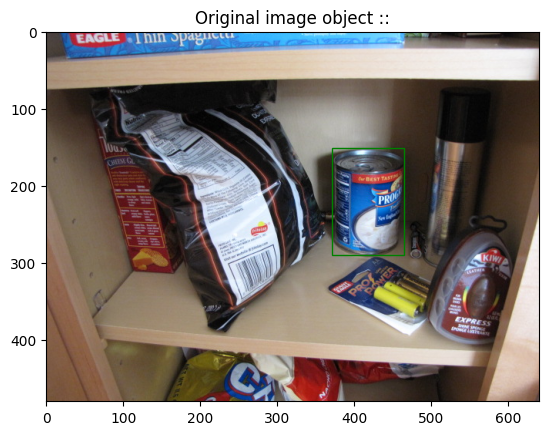

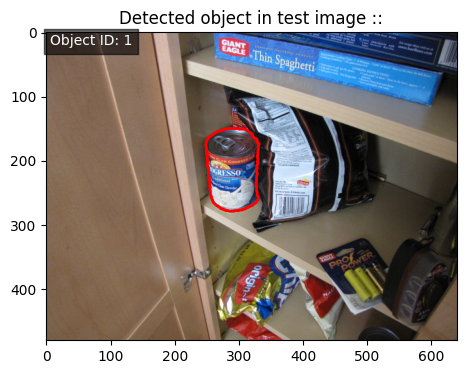

In [ ]:
img_prompt = r"D:/Codes/Assignments/ParallelDots/CMU10_3D/data_2D/can_chowder_000001.jpg"
mask_prompt = r"D:/Codes/Assignments/ParallelDots/CMU10_3D/data_2D/can_chowder_000001_1_gt.png"
test_img = r"D:/Codes/Assignments/ParallelDots/CMU10_3D/data_2D/can_chowder_000002.jpg"

bbox = process_img_png_mask(img_prompt, mask_prompt, visualize=False)
box_list = [(bbox, 1)]  

def track_item_boxes(imgpath1, imgpath2, img1boxclasslist, visualize=True):
    create_if_not_exists(tempfolder)
    cleardir(tempfolder)
    import shutil
    shutil.copy(imgpath1, tempfolder + "/00000.jpg")
    shutil.copy(imgpath2, tempfolder + "/00001.jpg")
    inference_state = predictor_vid.init_state(video_path="./tempdir")
    predictor_vid.reset_state(inference_state)
    ann_frame_idx = 0
    for img1boxclass in img1boxclasslist:
        ([xmin, xmax, ymin, ymax], objectnumint) = img1boxclass
        box = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)
        out = predictor_vid.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=objectnumint,
            box=box,
        )
        if isinstance(out, tuple) and len(out) == 2:
            out_obj_ids, out_mask_logits = out
        elif isinstance(out, tuple) and len(out) >= 2:
            out_obj_ids, out_mask_logits = out[0], out[1]
        elif isinstance(out, dict):
            out_obj_ids = out.get('obj_ids', None)
            out_mask_logits = out.get('mask_logits', None)
        else:
            print("Unexpected return type from add_new_points_or_box:", type(out))
            out_obj_ids, out_mask_logits = None, None

    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor_vid.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    if visualize:
        fig, ax = plt.subplots()
        plt.title(f"Original image object ::")
        ax.imshow(Image.open(tempfolder + "/00000.jpg"))
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='g', facecolor='none'
        )
        ax.add_patch(rect)
        plt.show()
        out_frame_idx = 1
        plt.figure(figsize=(6, 4))
        plt.title(f"Detected object in test image ::")
        plt.imshow(Image.open(tempfolder + "/00001.jpg"))
        if out_frame_idx in video_segments:
            for out_obj_id, out_mask in video_segments[out_frame_idx].items():
                mask2d = np.squeeze(out_mask)
                if mask2d.ndim != 2 or mask2d.shape[0] < 2 or mask2d.shape[1] < 2:
                    print(f"Warning: mask for object {out_obj_id} has shape {mask2d.shape}. Skipping contour plot.")
                    continue
                plt.contour(mask2d, colors=['r'], linewidths=2)
                plt.text(5, 20, f"Object ID: {out_obj_id}", color='white', bbox=dict(facecolor='black', alpha=0.6))
        plt.show()
    return video_segments

detection_result = track_item_boxes(img_prompt, test_img, box_list, visualize=True)



### Extract Predicted and Ground-Truth Bounding Boxes from Masks

Extracting tight bounding boxes from both the predicted and ground-truth masks for evaluation:

- **`bbox_from_mask(mask)`:**  
  This helper function finds the smallest rectangle that fully contains all non-zero pixels in a binary mask. It returns coordinates in `[xmin, xmax, ymin, ymax]` form for consistent metric evaluation.
    - If the mask is empty (no detected object), it returns `[0, 0, 0, 0]`.

- **Predicted Mask Processing:**
    - `detection_result[1]` retrieves the predicted masks for the test image (corresponds to the second image/frame in SAM2's API).
    - The code selects the first detected object’s mask (as there's typically only one).
    - `bbox_from_mask` is applied to get the predicted bounding box.
    - The predicted bounding box coordinates are printed for reference.

- **Ground-Truth Mask Processing:**
    - Loads the ground-truth mask for the test image directly from file.
    - Uses the same `bbox_from_mask` function to extract the ground-truth box.
    - Prints ground-truth bounding box coordinates.

These bounding boxes are essential for evaluating object detection accuracy (using Intersection over Union or IoU) in subsequent steps.


In [ ]:
def bbox_from_mask(mask):
    mask2d = np.squeeze(mask)
    rows = np.any(mask2d, axis=1)
    cols = np.any(mask2d, axis=0)
    if not rows.any() or not cols.any():
        return [0, 0, 0, 0]
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    return [int(xmin), int(xmax), int(ymin), int(ymax)]

predicted_masks_dict = detection_result[1]  
first_obj_id = next(iter(predicted_masks_dict.keys()))
pred_mask = predicted_masks_dict[first_obj_id]
pred_bbox = bbox_from_mask(pred_mask)
print("Predicted bounding box:", pred_bbox)

gt_mask_path = r"D:/Codes/Assignments/ParallelDots/CMU10_3D/data_2D/can_chowder_000002_1_gt.png"
gt_mask = np.array(Image.open(gt_mask_path))
gt_bbox = bbox_from_mask(gt_mask)
print("Ground-truth bounding box:", gt_bbox)


Predicted bounding box: [249, 331, 150, 278]
Ground-truth bounding box: [249, 336, 148, 278]


### Compute Intersection over Union (IoU) for Bounding Box Evaluation

Defining a function and evaluating the key metric for object detection performance:

- **`compute_bbox_iou(boxA, boxB)`:**  
  Given two bounding boxes in `[xmin, xmax, ymin, ymax]` format, this function calculates the Intersection over Union (IoU):

    - Finds the coordinates of the overlapping area between the two boxes.
    - Computes the intersection area and the areas of both boxes.
    - Calculates the union area and finally the IoU as the ratio: 
      \[
      \text{IoU} = \frac{\text{Area of Intersection}}{\text{Area of Union}}
      \]
    - Returns 0 if the boxes do not overlap or are degenerate (prevents division by zero).

- **Usage:**  
  Calculates and prints the IoU for the predicted vs. ground-truth bounding boxes extracted from the relevant masks.  
  A higher IoU indicates better overlap and thus higher detection accuracy for the selected image.


In [ ]:
def compute_bbox_iou(boxA, boxB):
    """
    boxA, boxB: [xmin, xmax, ymin, ymax]
    Returns IoU (float)
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[2], boxB[2])
    xB = min(boxA[1], boxB[1])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[1] - boxA[0]) * (boxA[3] - boxA[2])
    boxBArea = (boxB[1] - boxB[0]) * (boxB[3] - boxB[2])
    unionArea = boxAArea + boxBArea - interArea
    if unionArea == 0:
        return 0.0  
    iou = interArea / unionArea
    return iou

iou = compute_bbox_iou(pred_bbox, gt_bbox)
print(f"Intersection over Union (IoU) between prediction and ground-truth: {iou:.4f}")


Intersection over Union (IoU) between prediction and ground-truth: 0.9280


### Batch Evaluation: Compute IoU Across All Images of a Product

Performing automated batch evaluation of zero-shot object detection for a single product ("can_chowder"), as follows:

- **Image and Mask Discovery:**  
  - Lists and sorts all `.jpg` images and their corresponding ground-truth mask files for the selected product within the dataset directory.

- **Prompt Selection:**  
  - Uses the first image and its ground-truth mask as the prompt, extracting the bounding box and formatting it as input for the segmentation model.

- **Batch Detection and Evaluation:**  
  - Loops through all other images of this product (excluding the prompt image).
  - For each test image:
    - Runs detection with `track_item_boxes` using the prompt and prompt-derived bounding box.
    - Extracts the output mask, computes the predicted bounding box, and compares it to the ground-truth bounding box from the test mask using `compute_bbox_iou`.
    - Appends the IoU to a running list and prints the result for each image.

- **Result Aggregation:**  
  - After looping through all images, calculates and prints the mean IoU for the product, summarizing the zero-shot detection performance.


In [ ]:
import os

product = "can_chowder"
data2d = r"D:/Codes/Assignments/ParallelDots/CMU10_3D/data_2D"

img_files = sorted([f for f in os.listdir(data2d) if f.startswith(product) and f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(data2d) if f.startswith(product) and f.endswith('_gt.png')])

img_prompt = os.path.join(data2d, img_files[0])
mask_prompt = os.path.join(data2d, mask_files[0])
bbox = process_img_png_mask(img_prompt, mask_prompt, visualize=False)
box_list = [(bbox, 1)]

ious = []

for i in range(1, len(img_files)):
    test_img = os.path.join(data2d, img_files[i])
    gt_mask_path = os.path.join(data2d, mask_files[i])

    detection_result = track_item_boxes(img_prompt, test_img, box_list, visualize=False)

    pred_masks_dict = detection_result[1]
    if not pred_masks_dict:  
        print(f"{img_files[i]}: No detection, IoU = 0.0")
        ious.append(0.0)
        continue

    first_obj_id = next(iter(pred_masks_dict.keys()))
    pred_mask = pred_masks_dict[first_obj_id]
    pred_bbox = bbox_from_mask(pred_mask)
    gt_mask = np.array(Image.open(gt_mask_path))
    gt_bbox = bbox_from_mask(gt_mask)
    iou = compute_bbox_iou(pred_bbox, gt_bbox)
    print(f"{img_files[i]}: IoU = {iou:.4f}")
    ious.append(iou)

mean_iou = sum(ious) / len(ious) if ious else 0.0
print(f"\nMean IoU for {product}: {mean_iou:.4f}")


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.26it/s]


can_chowder_000002.jpg: IoU = 0.9280


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.73it/s]


can_chowder_000003.jpg: IoU = 0.9112


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 17.31it/s]


can_chowder_000004.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.48it/s]


can_chowder_000005.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.07it/s]


can_chowder_000006.jpg: IoU = 0.4835


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.91it/s]


can_chowder_000007.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 15.91it/s]


can_chowder_000008.jpg: IoU = 0.0738


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.51it/s]


can_chowder_000009.jpg: IoU = 0.1111


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 15.88it/s]


can_chowder_000010.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 15.39it/s]


can_chowder_000011.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.10it/s]


can_chowder_000012.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.61it/s]


can_chowder_000013.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.29it/s]


can_chowder_000014.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.02it/s]


can_chowder_000015.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.15it/s]


can_chowder_000016.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.85it/s]


can_chowder_000017.jpg: IoU = 0.0909


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.14it/s]


can_chowder_000018.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 17.10it/s]


can_chowder_000019.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.10it/s]


can_chowder_000020.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.74it/s]


can_chowder_000021.jpg: IoU = 0.0775


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.11it/s]


can_chowder_000022.jpg: IoU = 0.2316


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.22it/s]


can_chowder_000023.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.47it/s]


can_chowder_000024.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.52it/s]


can_chowder_000025.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 15.80it/s]


can_chowder_000026.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.02it/s]


can_chowder_000027.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.44it/s]


can_chowder_000028.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 17.36it/s]


can_chowder_000029.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 15.97it/s]


can_chowder_000030.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.96it/s]


can_chowder_000031.jpg: IoU = 0.0957


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.28it/s]


can_chowder_000032.jpg: IoU = 0.0009


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.57it/s]


can_chowder_000033.jpg: IoU = 0.0607


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.96it/s]


can_chowder_000034.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.24it/s]


can_chowder_000035.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.10it/s]


can_chowder_000036.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 15.67it/s]


can_chowder_000037.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.98it/s]


can_chowder_000038.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.13it/s]


can_chowder_000039.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.15it/s]


can_chowder_000040.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 17.07it/s]


can_chowder_000041.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.53it/s]


can_chowder_000042.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.53it/s]


can_chowder_000043.jpg: IoU = 0.3656


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 15.94it/s]


can_chowder_000044.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.60it/s]


can_chowder_000045.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.44it/s]


can_chowder_000046.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.38it/s]


can_chowder_000047.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.27it/s]


can_chowder_000048.jpg: IoU = 0.0000


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 17.66it/s]


can_chowder_000049.jpg: IoU = 0.1522


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 15.27it/s]

can_chowder_000050.jpg: IoU = 0.0000

Mean IoU for can_chowder: 0.0731


### Batch Evaluation: Mean IoU for All Products in Dataset

Performing a full evaluation across all product types in the dataset:

- **Product Discovery:**  
  - Automatically finds all unique product identifiers based on the naming convention in the data folder.

- **Per-Product Evaluation:**  
  - For each product, finds all associated images and masks.
  - Uses the first image/mask as the zero-shot prompt for SAM2.
  - Evaluates all remaining images, running detection, extracting predicted and ground-truth bounding boxes, and calculating IoU.
  - Appends each product’s mean IoU to a summary list.

- **Results Table:**  
  - After processing all products, creates a Pandas DataFrame summarizing the mean IoU for each product.
  - Prints this summary table for quick overview and reporting.
  - This table can be saved or visualized later as part of your results and analysis.


In [ ]:
!pip install pandas
import os

data2d = r"D:/Codes/Assignments/ParallelDots/CMU10_3D/data_2D"

all_files = os.listdir(data2d)
product_types = set(f.split('_')[0] + '_' + f.split('_')[1]
                   for f in all_files if f.endswith('.jpg') and '_' in f)

results = []

for product in sorted(product_types):
    img_files = sorted([f for f in all_files if f.startswith(product) and f.endswith('.jpg')])
    mask_files = sorted([f for f in all_files if f.startswith(product) and f.endswith('_gt.png')])
    if len(img_files) < 2 or len(mask_files) < 2:
        continue  
    img_prompt = os.path.join(data2d, img_files[0])
    mask_prompt = os.path.join(data2d, mask_files[0])
    bbox = process_img_png_mask(img_prompt, mask_prompt, visualize=False)
    box_list = [(bbox, 1)]
    ious = []
    for i in range(1, len(img_files)):
        test_img = os.path.join(data2d, img_files[i])
        gt_mask_path = os.path.join(data2d, mask_files[i])
        detection_result = track_item_boxes(img_prompt, test_img, box_list, visualize=False)
        pred_masks_dict = detection_result[1]
        if not pred_masks_dict:
            ious.append(0.0)
            continue
        first_obj_id = next(iter(pred_masks_dict.keys()))
        pred_mask = pred_masks_dict[first_obj_id]
        pred_bbox = bbox_from_mask(pred_mask)
        gt_mask = np.array(Image.open(gt_mask_path))
        gt_bbox = bbox_from_mask(gt_mask)
        iou = compute_bbox_iou(pred_bbox, gt_bbox)
        ious.append(iou)
    mean_iou = sum(ious) / len(ious) if ious else 0.0
    print(f"{product}: mean IoU = {mean_iou:.4f}")
    results.append((product, mean_iou))


import pandas as pd
df_results = pd.DataFrame(results, columns=['Product', 'Mean_IoU'])
print('\nSummary Table (Mean IoU per Product):\n')
print(df_results)



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.01it/s]


can_chowder: mean IoU = 0.0731


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


can_soymilk: mean IoU = 0.0545


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.89it/s]


can_tomatosoup: mean IoU = 0.0427


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 15.93it/s]


carton_oj: mean IoU = 0.1425


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.12it/s]


carton_soymilk: mean IoU = 0.1828


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.77it/s]


diet_coke: mean IoU = 0.1496


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 16.76it/s]


hc_potroastsoup: mean IoU = 0.1383


propagate in video: 100%|██████████| 2/2 [00:00<00:00, 15.17it/s]

rice_tuscan: mean IoU = 0.0938

Summary Table (Mean IoU per Product):

           Product  Mean_IoU
0      can_chowder  0.073113
1      can_soymilk  0.054502
2   can_tomatosoup  0.042684
3        carton_oj  0.142544
4   carton_soymilk  0.182847
5        diet_coke  0.149584
6  hc_potroastsoup  0.138263
7      rice_tuscan  0.093804


### Save Evaluation Results and Generate Summary Plot

Finalizing the evaluation process by performing two essential tasks for your assignment report:

- **Save Results Table to CSV:**  
  The full table of per-product mean IoU values (`df_results`) is saved as a CSV file in the `results` directory. This ensures your results are easily accessible for further analysis and review.

- **Create and Save a Bar Plot:**  
  A bar chart displays the mean IoU for each product, making it easy to visually compare model performance across different product types. The plot is also saved as a high-resolution PNG image in the `results` directory for inclusion in reports or presentations.

These steps complete the automated workflow by not only printing results but also exporting them in clear, shareable formats as professional practice.


Results saved to results/mean_iou_per_product.csv


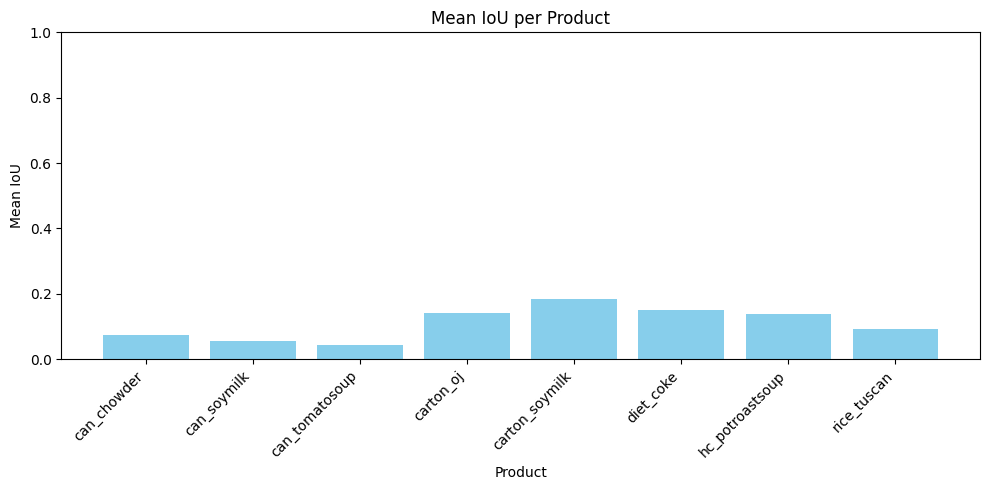

Plot saved to results/mean_iou_per_product.png


In [ ]:
import matplotlib.pyplot as plt
os.makedirs('results', exist_ok=True)

df_results.to_csv('results/mean_iou_per_product.csv', index=False)
print("Results saved to results/mean_iou_per_product.csv")

plt.figure(figsize=(10, 5))
plt.bar(df_results['Product'], df_results['Mean_IoU'], color='skyblue')
plt.title('Mean IoU per Product')
plt.xlabel('Product')
plt.ylabel('Mean IoU')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('results/mean_iou_per_product.png', dpi=200)
plt.show()
print("Plot saved to results/mean_iou_per_product.png")
